In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import regexp_extract, monotonically_increasing_id
from pyspark.sql.types import FloatType

# Initialize Spark Session
spark = SparkSession.builder.appName("ReviewsParser").getOrCreate()

# Read the text file
rdd = spark.sparkContext.textFile("gs://dataproc-staging-us-east1-766635705898-g9ye7adw/final_project/output5.txt")

# Initialize an empty list to collect rows
rows = []

# Temporary dictionary to store current review data
current_review = {}
for line in rdd.collect():
    if line.startswith("product/productId:"):
        # Start of a new review
        if current_review:
            # Add the completed review to the list
            rows.append(Row(**current_review))
            current_review = {}

    elif line.startswith("review/score:"):
        current_review["score"] = float(line.split(": ")[1])

    elif line.startswith("review/time:"):
        current_review["time"] = line.split(": ")[1]

    elif line.startswith("review/summary:"):
        current_review["summary"] = line.split(": ", 1)[1]

    elif line.startswith("review/text:"):
        current_review["text"] = line.split(": ", 1)[1]

    elif line.startswith("review/helpfulness:"):
        current_review["helpfulness"] = line.split(": ")[1]

# Don't forget to add the last review
if current_review:
    rows.append(Row(**current_review))

# Create an RDD from the list of rows
reviews_rdd = spark.sparkContext.parallelize(rows)

# Create DataFrame from RDD
df = spark.createDataFrame(reviews_rdd)

# Generate ID column
df = df.withColumn("id", monotonically_increasing_id())

# Calculate 'helpfulness' ratio
df = df.withColumn("helpfulness_ratio", 
                   (regexp_extract("helpfulness", r"(\d+)/", 1).cast(FloatType()) / 
                    regexp_extract("helpfulness", r"/(\d+)", 1).cast(FloatType())))

df = df.withColumn("total_review",regexp_extract("helpfulness", r"/(\d+)", 1).cast(FloatType()))
df0 = df.select("id", "score", "time", "summary", "text", "helpfulness_ratio","total_review")
df0.show()

23/12/08 20:54:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/12/08 20:54:26 WARN TaskSetManager: Stage 1 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 20:54:30 WARN TaskSetManager: Stage 2 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----------+--------------------+--------------------+------------------+------------+
| id|score|      time|             summary|                text| helpfulness_ratio|total_review|
+---+-----+----------+--------------------+--------------------+------------------+------------+
|  0|  3.0|1182729600|"There Is So Much...|Synopsis: On the ...|               1.0|         7.0|
|  1|  3.0|1181952000|Worthwhile and Im...|THE VIRGIN OF JUA...|               1.0|         4.0|
|  2|  5.0|1164844800|This movie needed...|The scenes in thi...|               0.8|        10.0|
|  3|  3.0|1197158400|distantly based o...|THE VIRGIN OF JUA...|               1.0|         1.0|
|  4|  3.0|1188345600|"What's going on ...|Informationally, ...|               1.0|         1.0|
|  5|  2.0|1229040000|Pretty pointless ...|The murders in Ju...|              null|         0.0|
|  6|  1.0|1164153600|This is junk, sta...|Mexican men are m...|0.2727272727272727|        11.0|
|  7|  5.0|1060473600|A  Rock 

In [2]:
# using filter function to delete rows
df_filtered = df0.filter(df0['total_review'] >= 8)
df_filtered.show()

23/12/08 20:55:19 WARN TaskSetManager: Stage 3 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----------+--------------------+--------------------+------------------+------------+
| id|score|      time|             summary|                text| helpfulness_ratio|total_review|
+---+-----+----------+--------------------+--------------------+------------------+------------+
|  2|  5.0|1164844800|This movie needed...|The scenes in thi...|               0.8|        10.0|
|  6|  1.0|1164153600|This is junk, sta...|Mexican men are m...|0.2727272727272727|        11.0|
|  7|  5.0|1060473600|A  Rock N Roll Hi...|Over the past few...|0.9846153846153847|        65.0|
|  8|  5.0|1041292800|A  MUST-HAVE  vid...|I recvd this vide...|               1.0|        26.0|
|  9|  5.0|1061164800|If You Like DooWo...|Wow! When I saw t...|               1.0|        24.0|
| 10|  4.0|1039564800|    I expected more.|I have the Doo Wo...|0.9565217391304348|        23.0|
| 11|  5.0|1045526400|Professional Exce...|Having worked in ...|               1.0|        14.0|
| 12|  5.0|1062979200|Marvelou

In [3]:
# Get the number of rows
num_rows = df_filtered.count()

# Get the number of columns
num_columns = len(df_filtered.columns)

# Print the shape of the DataFrame
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
df0.schema

23/12/08 20:55:36 WARN TaskSetManager: Stage 4 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows: 72004
Number of columns: 7


StructType([StructField('id', LongType(), False), StructField('score', DoubleType(), True), StructField('time', StringType(), True), StructField('summary', StringType(), True), StructField('text', StringType(), True), StructField('helpfulness_ratio', DoubleType(), True), StructField('total_review', FloatType(), True)])

In [4]:
from pyspark.sql.functions import col, sum

# Calculate the number of missing values in each column
df_missing = df_filtered.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_filtered.columns))
df_missing.show()

23/12/08 20:55:45 WARN TaskSetManager: Stage 7 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----+-------+----+-----------------+------------+
| id|score|time|summary|text|helpfulness_ratio|total_review|
+---+-----+----+-------+----+-----------------+------------+
|  0|    0|   0|      0|   0|                0|           0|
+---+-----+----+-------+----+-----------------+------------+



In [5]:
# Drop rows with any missing value
df_filtered = df_filtered.dropna()
df0_missing = df_filtered.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_filtered.columns))
df0_missing.show()

23/12/08 20:55:50 WARN TaskSetManager: Stage 10 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----+-------+----+-----------------+------------+
| id|score|time|summary|text|helpfulness_ratio|total_review|
+---+-----+----+-------+----+-----------------+------------+
|  0|    0|   0|      0|   0|                0|           0|
+---+-----+----+-------+----+-----------------+------------+



In [6]:
# Get the number of rows
num_rows = df_filtered.count()

# Get the number of columns
num_columns = len(df_filtered.columns)

# Print the shape of the DataFrame
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

23/12/08 20:56:04 WARN TaskSetManager: Stage 13 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows: 72004
Number of columns: 7


In [7]:
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev

# Calculating the mean for the 'score' column
mean_value = df_filtered.select(mean(df_filtered['score'])).collect()[0][0]
mean_value1 = df_filtered.select(mean(df_filtered['helpfulness_ratio'])).collect()[0][0]
std_dev_helpfulness = df_filtered.select(stddev(df_filtered['helpfulness_ratio'])).collect()[0][0]
median_helpfulness = df_filtered.stat.approxQuantile('helpfulness_ratio', [0.5], 0.0)[0]

print("Mean of score:", mean_value)
print("Mean of helpfulness_ratio:", mean_value1)
print("Standard Deviation of helpfulness_ratio:", std_dev_helpfulness)
print("Median of helpfulness_ratio:", median_helpfulness)

23/12/08 20:56:09 WARN TaskSetManager: Stage 16 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 20:56:11 WARN TaskSetManager: Stage 19 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 20:56:14 WARN TaskSetManager: Stage 22 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 20:56:16 WARN TaskSetManager: Stage 25 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Mean of score: 3.2923587578467863
Mean of helpfulness_ratio: 0.611540719977673
Standard Deviation of helpfulness_ratio: 0.3129642417738818
Median of helpfulness_ratio: 0.6923076923076923


23/12/08 20:56:20 WARN TaskSetManager: Stage 26 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


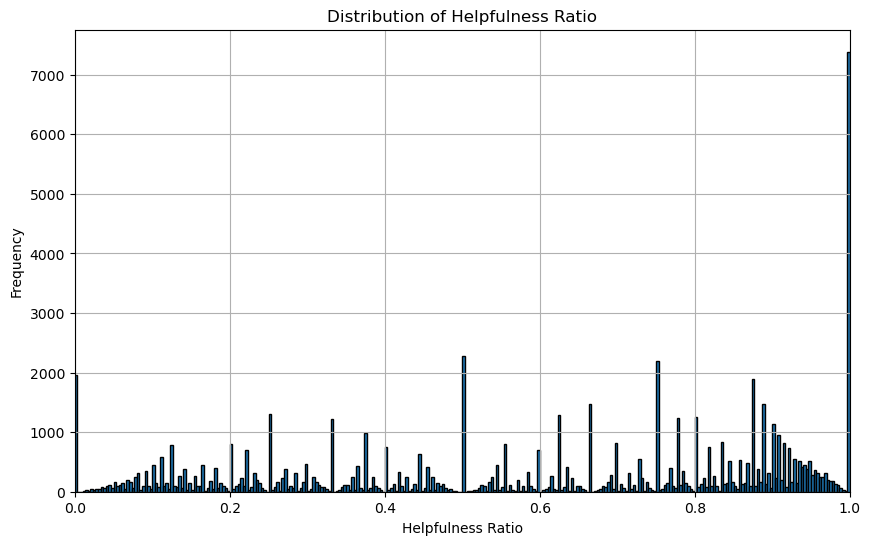

0.8275862068965517


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Convert to Pandas DataFrame
helpfulness_pd = df_filtered.select("helpfulness_ratio").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(helpfulness_pd['helpfulness_ratio'], bins=300, edgecolor='black')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 1)  # Setting the limit for the X-axis
plt.grid(True)
plt.show()

t = np.percentile(helpfulness_pd['helpfulness_ratio'],65)
print(t)


In [9]:
# Check unique values in the 'score' column
unique_scores = df_filtered.select("score").distinct().orderBy("score").collect()
print("Unique scores:", [row.score for row in unique_scores])


23/12/08 20:56:23 WARN TaskSetManager: Stage 27 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Unique scores: [1.0, 2.0, 3.0, 4.0, 5.0]


In [10]:
# Select columns for df_X and df_y
df_X = df_filtered.select("id", "score", "time", "summary", "text")
df_y = df_filtered.select("id", "helpfulness_ratio","total_review")

# Show DataFrames
df_X.show()
df_y.show()


# Get the number of rows
Xnum_rows = df_X.count()

# Get the number of columns
Xnum_columns = len(df_X.columns)

# Print the shape of the DataFrame
print(f"Number of rows in feaures df: {Xnum_rows}")
print(f"Number of columns: {Xnum_columns}")
# Get the number of rows
ynum_rows = df_y.count()

# Get the number of columns
ynum_columns = len(df_y.columns)

# Print the shape of the DataFrame
print(f"Number of rows in target df: {ynum_rows}")
print(f"Number of columns in target df: {ynum_columns}")

23/12/08 20:56:42 WARN TaskSetManager: Stage 35 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 20:56:46 WARN TaskSetManager: Stage 36 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----------+--------------------+--------------------+
| id|score|      time|             summary|                text|
+---+-----+----------+--------------------+--------------------+
|  2|  5.0|1164844800|This movie needed...|The scenes in thi...|
|  6|  1.0|1164153600|This is junk, sta...|Mexican men are m...|
|  7|  5.0|1060473600|A  Rock N Roll Hi...|Over the past few...|
|  8|  5.0|1041292800|A  MUST-HAVE  vid...|I recvd this vide...|
|  9|  5.0|1061164800|If You Like DooWo...|Wow! When I saw t...|
| 10|  4.0|1039564800|    I expected more.|I have the Doo Wo...|
| 11|  5.0|1045526400|Professional Exce...|Having worked in ...|
| 12|  5.0|1062979200|Marvelous, just M...|The people who ha...|
| 13|  5.0|1042502400|Pittsburgh - Home...|I have all of the...|
| 20|  5.0|1070064000|far from home: th...|well,this just go...|
| 21|  5.0|1092441600|Spectacular and s...|The cover of our ...|
| 22|  5.0| 964915200|A truly wonderful...|I would beg to di...|
| 53|  5.0|1012003200|As 

23/12/08 20:56:51 WARN TaskSetManager: Stage 37 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+------------------+------------+
| id| helpfulness_ratio|total_review|
+---+------------------+------------+
|  2|               0.8|        10.0|
|  6|0.2727272727272727|        11.0|
|  7|0.9846153846153847|        65.0|
|  8|               1.0|        26.0|
|  9|               1.0|        24.0|
| 10|0.9565217391304348|        23.0|
| 11|               1.0|        14.0|
| 12|               1.0|         9.0|
| 13|               1.0|         9.0|
| 20|0.9473684210526315|        19.0|
| 21|0.9333333333333333|        15.0|
| 22|0.9090909090909091|        11.0|
| 53|0.9714285714285714|        35.0|
|129|0.9405204460966543|       269.0|
|130|0.9454545454545454|       110.0|
|131|0.9550561797752809|        89.0|
|132|0.9629629629629629|        27.0|
|133|0.9117647058823529|        34.0|
|134|0.9230769230769231|        26.0|
|135|             0.875|        32.0|
+---+------------------+------------+
only showing top 20 rows



23/12/08 20:56:53 WARN TaskSetManager: Stage 40 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows in feaures df: 72004
Number of columns: 5


Number of rows in target df: 72004
Number of columns in target df: 3


In [11]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col, from_unixtime, to_date
from pyspark.ml import Pipeline

# # One-Hot Encoding
# encoder = OneHotEncoder(inputCols=["score"], outputCols=["scoreVec"])

# # Pipeline
# pipeline = Pipeline(stages=[encoder])

# # Fit and Transform
# model = pipeline.fit(df_X)
# df_encoded = model.transform(df_X)
# df_encoded = df_encoded.drop('score')

df_encoded = df_X.withColumn("timestamp", to_date(from_unixtime(col("time").cast("long"))))
df_encoded= df_encoded.drop('time')
df_encoded.show()

23/12/08 20:59:57 WARN TaskSetManager: Stage 43 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+--------------------+--------------------+----------+
| id|score|             summary|                text| timestamp|
+---+-----+--------------------+--------------------+----------+
|  2|  5.0|This movie needed...|The scenes in thi...|2006-11-30|
|  6|  1.0|This is junk, sta...|Mexican men are m...|2006-11-22|
|  7|  5.0|A  Rock N Roll Hi...|Over the past few...|2003-08-10|
|  8|  5.0|A  MUST-HAVE  vid...|I recvd this vide...|2002-12-31|
|  9|  5.0|If You Like DooWo...|Wow! When I saw t...|2003-08-18|
| 10|  4.0|    I expected more.|I have the Doo Wo...|2002-12-11|
| 11|  5.0|Professional Exce...|Having worked in ...|2003-02-18|
| 12|  5.0|Marvelous, just M...|The people who ha...|2003-09-08|
| 13|  5.0|Pittsburgh - Home...|I have all of the...|2003-01-14|
| 20|  5.0|far from home: th...|well,this just go...|2003-11-29|
| 21|  5.0|Spectacular and s...|The cover of our ...|2004-08-14|
| 22|  5.0|A truly wonderful...|I would beg to di...|2000-07-30|
| 53|  5.0|As Crisp As A 

In [16]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Assuming 'timestamp' is your column with the date/time information
df_encoded = df_encoded.withColumn("day", dayofweek(df_encoded["timestamp"]))

# Determine whether it's a weekday or weekend
df_encoded = df_encoded.withColumn("if_weekday", 
                                   when(df_encoded["day"].isin([1, 7]), "0")
                                   .otherwise("1"))


# # String Indexing for the 'weekdayOrWeekend' and 'periodOfDay' columns
# indexer1 = StringIndexer(inputCol="weekday", outputCol="weekdayOrWeekendIndex")

# # One-Hot Encoding
# encoder1 = OneHotEncoder(inputCols=["weekdayOrWeekendIndex"], outputCols=["weekdayOrWeekendVec"])

# # Define the pipeline
# pipeline = Pipeline(stages=[indexer1,encoder1])

# # Fit and Transform
# model = pipeline.fit(df_encoded)
# df_encoded = model.transform(df_encoded)

# df_encoded =df_encoded.drop('day','weekday','weekdayOrWeekendIndex')

from pyspark.sql.functions import length

# Calculating length of text and summary
df_encoded = df_encoded.withColumn("text_length", length(col("text")))
df_encoded = df_encoded.withColumn("summary_length", length(col("summary")))
df_encoded.show()
df_encoded =df_encoded.drop('day','1','timestamp')

df_encoded.show()

23/12/08 21:04:41 WARN TaskSetManager: Stage 46 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+--------------------+--------------------+-----------+--------------+----------+
| id|score|             summary|                text|text_length|summary_length|if_weekday|
+---+-----+--------------------+--------------------+-----------+--------------+----------+
|  2|  5.0|This movie needed...|The scenes in thi...|        842|            29|         1|
|  6|  1.0|This is junk, sta...|Mexican men are m...|        300|            23|         1|
|  7|  5.0|A  Rock N Roll Hi...|Over the past few...|       1709|            29|         0|
|  8|  5.0|A  MUST-HAVE  vid...|I recvd this vide...|       1072|            54|         1|
|  9|  5.0|If You Like DooWo...|Wow! When I saw t...|        725|            42|         1|
| 10|  4.0|    I expected more.|I have the Doo Wo...|       1423|            16|         1|
| 11|  5.0|Professional Exce...|Having worked in ...|        675|            23|         1|
| 12|  5.0|Marvelous, just M...|The people who ha...|        309|            26|

In [17]:

# initialize pre-trained vader model
import nltk
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
# using vader to predict the score of text and summary
txt = df_encoded.select("text").toPandas()
txt_sum = df_encoded.select("summary").toPandas()
txt['summary'] = txt_sum['summary']
txt['text_score'] = txt['text'].apply(lambda x: sia.polarity_scores(x))
txt['sum_score'] = txt['summary'].apply(lambda x: sia.polarity_scores(x))
txt['text_neg'] = txt['text_score'].apply(lambda x: x['neg'])
txt['text_neu'] = txt['text_score'].apply(lambda x: x['neu'])
txt['text_pos'] = txt['text_score'].apply(lambda x: x['pos'])
txt['text_compound_score'] = txt['text_score'].apply(lambda x: x['compound'])
txt['sum_neg'] = txt['sum_score'].apply(lambda x: x['neg'])
txt['sum_neu'] = txt['sum_score'].apply(lambda x: x['neu'])
txt['sum_pos'] = txt['sum_score'].apply(lambda x: x['pos'])
txt['sum_compound_score'] = txt['sum_score'].apply(lambda x: x['compound'])

# # extracting the compund score of the training results
# fea = txt.drop('text',axis = 1)
# fea = fea.drop('summary',axis = 1)
fea = txt.drop('text_score',axis = 1)
fea = fea.drop('sum_score',axis = 1)
fea

,text,summary,text_neg,text_neu,text_pos,text_compound_score,sum_neg,sum_neu,sum_pos,sum_compound_score
0,The scenes in this film can be very disquietin...,This movie needed to be made.,0.262,0.660,0.078,-0.9901,0.000,1.000,0.000,0.0000
1,"Mexican men are macho rapists, gangsters or in...","This is junk, stay away",0.294,0.668,0.038,-0.9062,0.000,1.000,0.000,0.0000
2,"Over the past few years, public television has...",A Rock N Roll History Lesson,0.017,0.876,0.107,0.9792,0.000,1.000,0.000,0.0000
3,I recvd this video (DVD version) as a Christma...,A MUST-HAVE video if you grew up in the 50's...,0.005,0.796,0.199,0.9904,0.000,1.000,0.000,0.0000
4,"Wow! When I saw this show on PBS--that was it,...",If You Like DooWop You Gotta Have This DVD,0.018,0.858,0.124,0.9345,0.000,0.762,0.238,0.3612
...,...,...,...,...,...,...,...,...,...,...
71999,I'm a Sam Elliott fan ... and this was a good ...,You Know My Name,0.136,0.753,0.111,-0.8794,0.000,1.000,0.000,0.0000
72000,Sam Elliott's portrait of Marshal Tilghman is ...,"Good cast, lousy script",0.160,0.651,0.190,0.7081,0.417,0.238,0.345,-0.1531
72001,This movie is not worth Sam Elliot. I was ver...,Dissapointed,0.100,0.900,0.000,-0.1695,0.000,1.000,0.000,0.0000
72002,I'm a Sam Elliott fan ... and this was a good ...,You Know My Name,0.136,0.753,0.111,-0.8794,0.000,1.000,0.000,0.0000


In [21]:
from pyspark.sql.functions import when, col,rank
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd

# Creating a new column 'is_helpful' that is 1 if helpfulness_ratio > 0.8 and 0 otherwise
df_y = df_y.withColumn("is_helpful", when(col("helpfulness_ratio") > 0.85, 1).otherwise(0))

# Showing the updated DataFrame
df_y.show()

# Calculating the percentage of records where helpfulness_ratio > 0.8
total_count = df_y.count()
helpful_count = df_y.filter(col("is_helpful") == 1).count()
percentage_helpful = (helpful_count / total_count) * 100

print(f"Percentage of reviews with helpfulness_ratio > 0.85: {percentage_helpful:.2f}%")


23/12/08 21:12:52 WARN TaskSetManager: Stage 51 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 21:12:57 WARN TaskSetManager: Stage 52 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+------------------+------------+----------+
| id| helpfulness_ratio|total_review|is_helpful|
+---+------------------+------------+----------+
|  2|               0.8|        10.0|         0|
|  6|0.2727272727272727|        11.0|         0|
|  7|0.9846153846153847|        65.0|         1|
|  8|               1.0|        26.0|         1|
|  9|               1.0|        24.0|         1|
| 10|0.9565217391304348|        23.0|         1|
| 11|               1.0|        14.0|         1|
| 12|               1.0|         9.0|         1|
| 13|               1.0|         9.0|         1|
| 20|0.9473684210526315|        19.0|         1|
| 21|0.9333333333333333|        15.0|         1|
| 22|0.9090909090909091|        11.0|         1|
| 53|0.9714285714285714|        35.0|         1|
|129|0.9405204460966543|       269.0|         1|
|130|0.9454545454545454|       110.0|         1|
|131|0.9550561797752809|        89.0|         1|
|132|0.9629629629629629|        27.0|         1|
|133|0.9117647058823

23/12/08 21:12:59 WARN TaskSetManager: Stage 55 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Percentage of reviews with helpfulness_ratio > 0.85: 32.42%


In [30]:
# combine the feature and predicted output into one data frame 
feature = df_encoded.toPandas()
result = pd.concat([feature, fea], axis=1)
result = result.drop('id',axis=1)
pred = df_y.drop("id","helpfulness_ratio","total_review").toPandas()
result = pd.concat([result,pred],axis=1)
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(result)
spark_df.show()

23/12/08 21:21:35 WARN TaskSetManager: Stage 70 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 21:21:39 WARN TaskSetManager: Stage 71 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/12/08 21:21:46 WARN TaskSetManager: Stage 72 contains a task of very large size (25765 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+-----------+--------------+----------+--------+--------+--------+-------------------+-------+-------+-------+------------------+----------+
|score|             summary|                text|text_length|summary_length|if_weekday|text_neg|text_neu|text_pos|text_compound_score|sum_neg|sum_neu|sum_pos|sum_compound_score|is_helpful|
+-----+--------------------+--------------------+-----------+--------------+----------+--------+--------+--------+-------------------+-------+-------+-------+------------------+----------+
|  5.0|This movie needed...|The scenes in thi...|        842|            29|         1|   0.262|    0.66|   0.078|            -0.9901|    0.0|    1.0|    0.0|               0.0|         0|
|  1.0|This is junk, sta...|Mexican men are m...|        300|            23|         1|   0.294|   0.668|   0.038|            -0.9062|    0.0|    1.0|    0.0|               0.0|         0|
|  5.0|A  Rock N Roll Hi...|Over the past few...|      

In [31]:
spark_df = spark_df.drop("timestamp")
spark_df.show()
spark_df.schema

23/12/08 21:21:57 WARN TaskSetManager: Stage 73 contains a task of very large size (25765 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+-----------+--------------+----------+--------+--------+--------+-------------------+-------+-------+-------+------------------+----------+
|score|             summary|                text|text_length|summary_length|if_weekday|text_neg|text_neu|text_pos|text_compound_score|sum_neg|sum_neu|sum_pos|sum_compound_score|is_helpful|
+-----+--------------------+--------------------+-----------+--------------+----------+--------+--------+--------+-------------------+-------+-------+-------+------------------+----------+
|  5.0|This movie needed...|The scenes in thi...|        842|            29|         1|   0.262|    0.66|   0.078|            -0.9901|    0.0|    1.0|    0.0|               0.0|         0|
|  1.0|This is junk, sta...|Mexican men are m...|        300|            23|         1|   0.294|   0.668|   0.038|            -0.9062|    0.0|    1.0|    0.0|               0.0|         0|
|  5.0|A  Rock N Roll Hi...|Over the past few...|      

StructType([StructField('score', DoubleType(), True), StructField('summary', StringType(), True), StructField('text', StringType(), True), StructField('text_length', LongType(), True), StructField('summary_length', LongType(), True), StructField('if_weekday', StringType(), True), StructField('text_neg', DoubleType(), True), StructField('text_neu', DoubleType(), True), StructField('text_pos', DoubleType(), True), StructField('text_compound_score', DoubleType(), True), StructField('sum_neg', DoubleType(), True), StructField('sum_neu', DoubleType(), True), StructField('sum_pos', DoubleType(), True), StructField('sum_compound_score', DoubleType(), True), StructField('is_helpful', LongType(), True)])

In [32]:
#spark_df.write.json("gs://dataproc-staging-us-east1-1041616805845-wwof0qwm/data/feature.json", compression="gzip", mode="overwrite", lineSep=None)
df_repartitioned = spark_df.repartition(1)  # make the data in one area
df_repartitioned.write.json("gs://dataproc-staging-us-east1-766635705898-g9ye7adw/final_project/df.json", mode="overwrite")

23/12/08 21:22:13 WARN TaskSetManager: Stage 74 contains a task of very large size (25765 KiB). The maximum recommended task size is 1000 KiB.
